In [1]:
# Importing libraries
import pandas as pd
from tqdm import tqdm, tqdm_notebook 
from itertools import product
from math import sqrt
import datetime  
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import numpy as np
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

# We will use deprecated models of statmodels which throw a lot of warnings 
# to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

In [2]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))

def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [3]:
energy_per_month = pd.read_csv('energy_sum_month.csv', sep=",", parse_dates=True)
energy_per_month.head(2)

,timestamp,coal,nuclear,wind,hydro,solar,total
0,2012-01-31,1.557582e+08,6.846972e+07,1.539371e+07,6.375348e+06,0.0,2.459970e+08
1,2012-02-29,1.690382e+08,6.966962e+07,1.363287e+07,4.662923e+06,0.0,2.570037e+08


In [4]:
energy_per_month['Datetime']=pd.to_datetime(energy_per_month['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [5]:
energy_per_month['Date'] = energy_per_month['Datetime'].dt.date
energy_per_month['Year'] = energy_per_month['Datetime'].dt.year
energy_per_month['Month'] = energy_per_month['Datetime'].dt.month.astype(int)
energy_per_month['day_of_month'] = energy_per_month['Datetime'].dt.day.astype(int)

# day_of_week=0 corresponds to Monday
energy_per_month['day_of_week'] = energy_per_month['Datetime'].dt.dayofweek.astype(int)
energy_per_month['hour_of_day'] = energy_per_month['Datetime'].dt.hour.astype(int)
energy_per_month['day_of_week_name'] = energy_per_month['Datetime'].dt.day_name()
energy_per_month['month_name'] = energy_per_month['Datetime'].dt.month_name()

In [6]:
energy_per_month.set_index('Datetime', inplace=True)

In [7]:
energy_per_month.head(2)

,timestamp,coal,nuclear,wind,hydro,solar,total,Date,Year,Month,day_of_month,day_of_week,hour_of_day,day_of_week_name,month_name
Datetime,,,,,,,,,,,,,,,
2012-01-31,2012-01-31,1.557582e+08,6.846972e+07,1.539371e+07,6.375348e+06,0.0,2.459970e+08,2012-01-31,2012,1,31,1,0,Tuesday,January
2012-02-29,2012-02-29,1.690382e+08,6.966962e+07,1.363287e+07,4.662923e+06,0.0,2.570037e+08,2012-02-29,2012,2,29,2,0,Wednesday,February


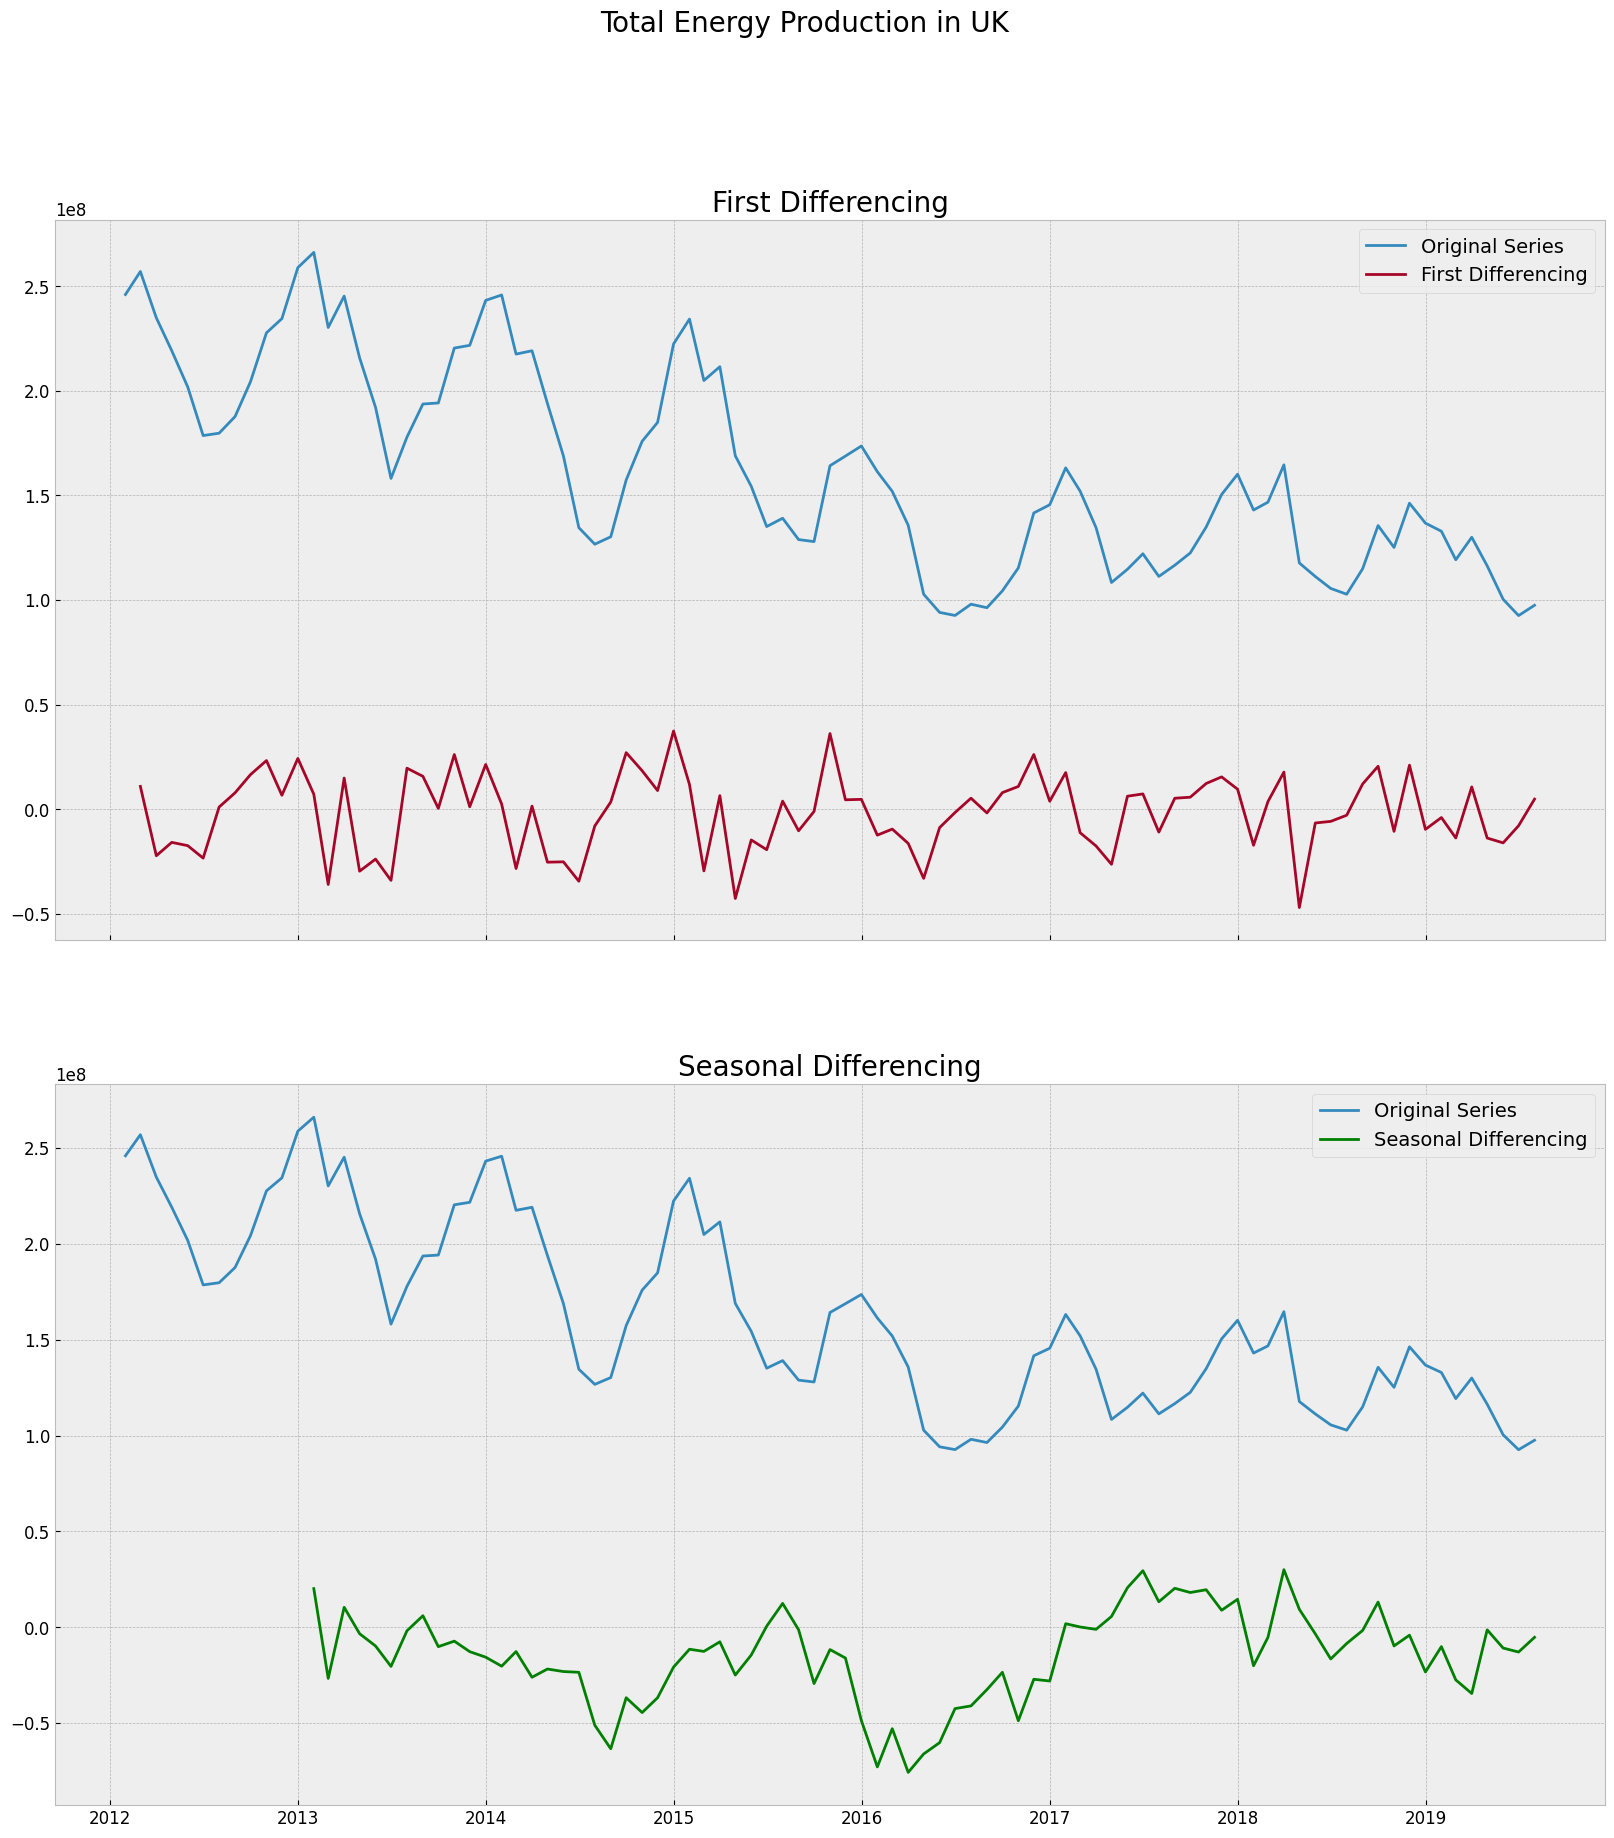

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(20,21), dpi=100, sharex=True)

# Differencing lag = 1
axes[0].plot(energy_per_month['total'], label='Original Series')
axes[0].plot(energy_per_month['total'].diff(1), label='First Differencing')
axes[0].set_title('First Differencing', fontsize=20)
axes[0].legend(loc='upper right', fontsize=14)


# Seasonal Differencing lag = 12
axes[1].plot(energy_per_month['total'], label='Original Series')
axes[1].plot(energy_per_month['total'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing', fontsize=20)
plt.legend(loc='upper right', fontsize=14)
plt.suptitle('Total Energy Production in UK', fontsize=20)
plt.show()

In [9]:
# Define the p and q parameters to take any value between 2 and 5/6, 5/6 excluded
ps = range(2, 5)
qs = range(2, 6)
d = 1 

# Define the Ps and Qs parameters to take any value between 0 and 3/6, 3/6 excluded
Ps = range(0, 2)
Qs = range(0, 2)
D = 1 # seasonal differencing  is needed
s = 12 # season's length is 12

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

### Preparing training and testing data sets

In [10]:
# We split our dataset into a train and a test set
arima_data = energy_per_month['total']
resultsDict = {}
predictionsDict = {}

split_date = '2018-12-31'
df_training = arima_data.loc[arima_data.index <= split_date]
df_test = arima_data.loc[arima_data.index > split_date]
print(f"{len(df_training)} months of training data \n {len(df_test)} months of testing data ")

84 months of training data 
 7 months of testing data 


## SARIMA Grid Search

In [11]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=SARIMAX(y, 
                          order=(param[0], 
                                 d, param[1]), 
                                 seasonal_order=(param[2], 
                                 D, param[3], s)).fit(disp=-1)
        except:
            continue
            print('Exception')
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [12]:
%%time
warnings.filterwarnings("ignore") # specify to ignore warning messages
sarima_optimal_parameters = optimizeSARIMA(df_training, parameters_list, d, D, s)

  0%|          | 0/48 [00:00<?, ?it/s]

CPU times: user 1min 52s, sys: 47.9 s, total: 2min 40s
Wall time: 41.6 s


In [13]:
sarima_optimal_parameters.head(5)

,parameters,aic
0,"(2, 2, 1, 1)",2560.233901
1,"(2, 5, 0, 1)",2561.543341
2,"(2, 5, 0, 0)",2561.675480
3,"(2, 5, 1, 0)",2561.882096
4,"(3, 2, 1, 1)",2562.149825


### Building SARIMA model


Nous avons choisi d'utiliser la combinaison des paramètres (2, 5, 0, 1) car ce modèle se charactérise avec des coefficients statistiquement signifiants (p < 0.05) pour plus des termes AR et MA. 

In [14]:
# build a model with the parameters that give the lowest AIC
p, q, P, Q = sarima_optimal_parameters.parameters[1]
best_model=SARIMAX(df_training, order=(p, d, q), 
                                seasonal_order=(P, D, Q, s),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                total   No. Observations:                   84
Model:             SARIMAX(2, 1, 5)x(0, 1, [1], 12)   Log Likelihood                -945.406
Date:                              Mon, 25 Oct 2021   AIC                           1908.812
Time:                                      00:30:23   BIC                           1926.545
Sample:                                  01-31-2012   HQIC                          1915.631
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1811      0.292     -4.047      0.000      -1.753      -0.609
ar.L2         -0.67

## Residual statistics

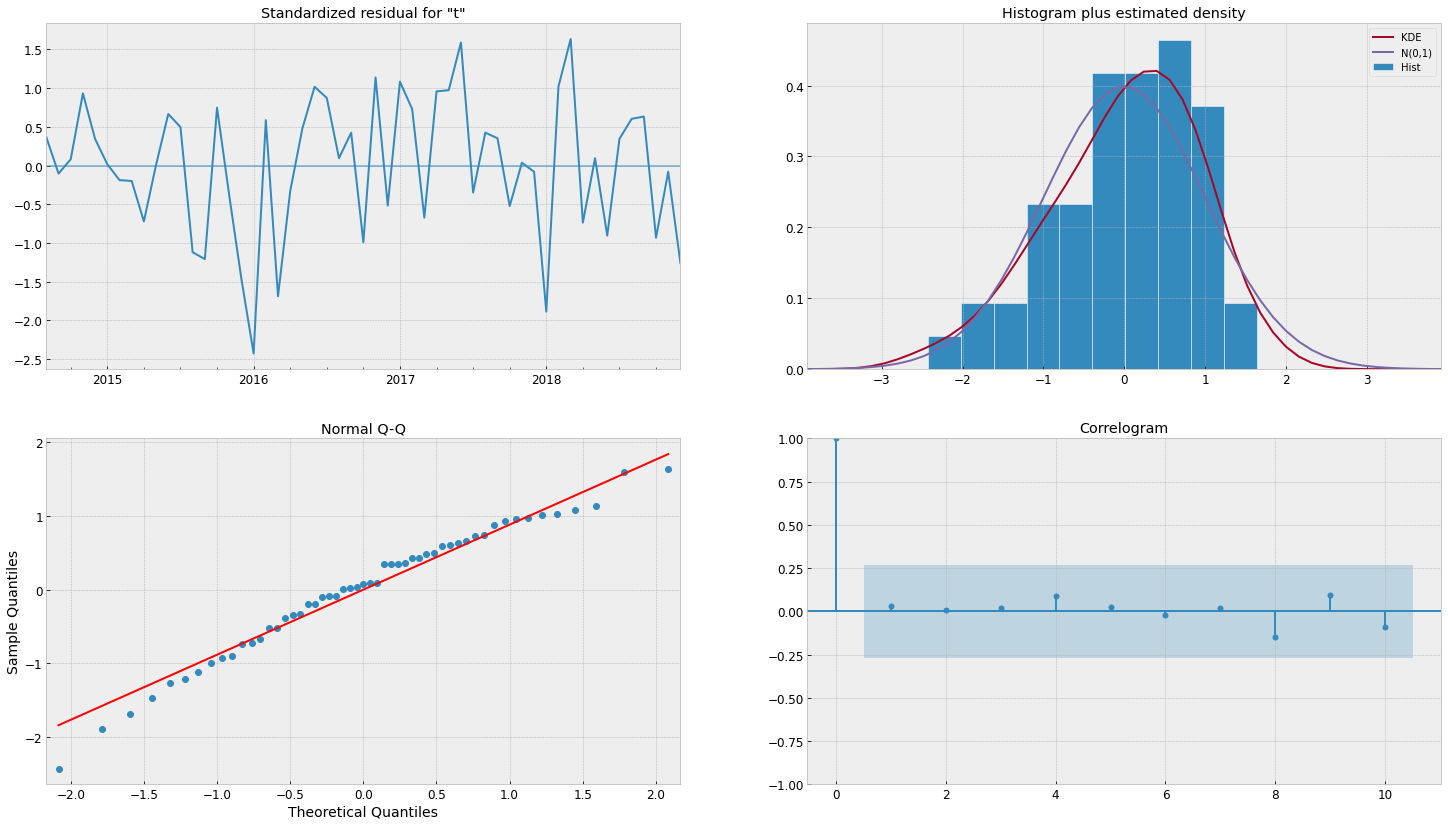

In [15]:
best_model.plot_diagnostics(figsize=(25, 14))
plt.show()

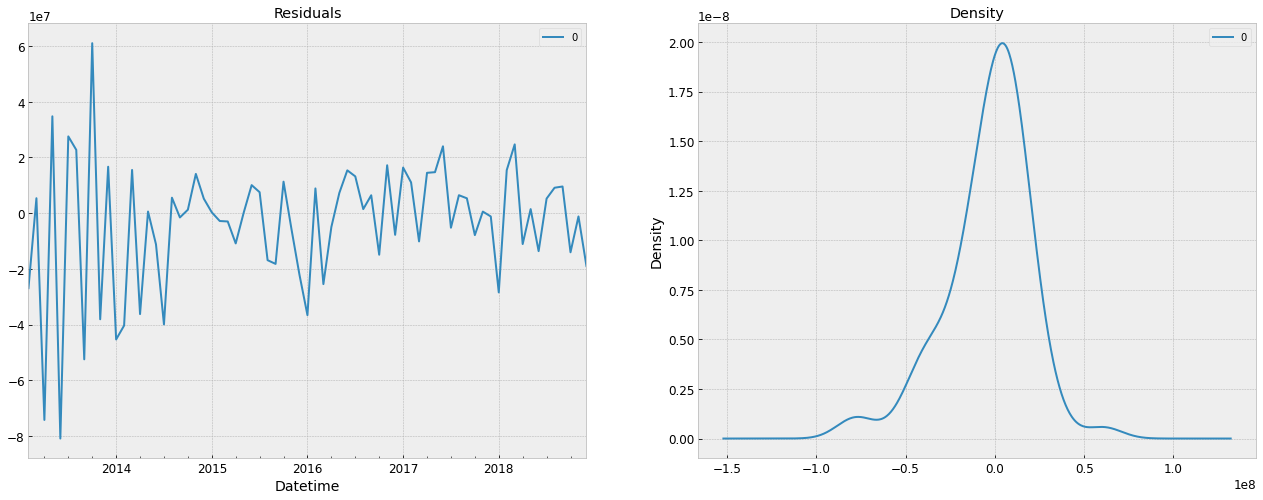

In [16]:
# Plot residual errors for the ARMA (2, 0, 5 model)
residuals = pd.DataFrame(best_model.resid[12+1:])
fig, ax = plt.subplots(1,2, figsize=(22,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

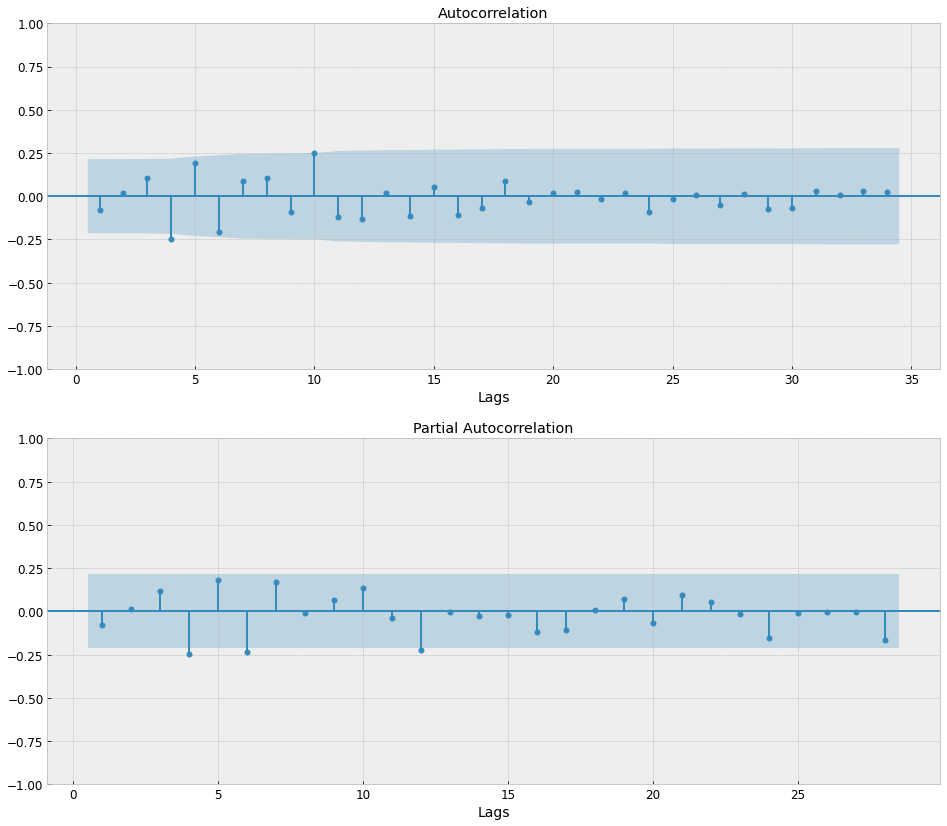

In [17]:
# ACF, PACF graphs for the residuals
fig = plt.figure(figsize=(16,14))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Lags', fontsize=14)
fig = plot_acf(best_model.resid.values, zero = False, lags=34, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Lags', fontsize=14)
fig = plot_pacf(best_model.resid.values, zero = False,  lags=28, ax=ax2)  # first value of diff is NaN

In [18]:
def adftest(ts):
    print ('Augmented Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used For ADF Regression and Critical Values Calculation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [19]:
adftest(best_model.resid)

Augmented Dickey-Fuller Test:
Test Statistic                                                                    -3.686465
p-value                                                                            0.004308
#Lags Used                                                                         5.000000
Number of Observations Used For ADF Regression and Critical Values Calculation    78.000000
Critical Value (1%)                                                               -3.517114
Critical Value (5%)                                                               -2.899375
Critical Value (10%)                                                              -2.586955
dtype: float64


Les erreurs résiduelles fluctuent autour d'une moyenne = 0 et elles ont une variance uniforme. Leur distribution s'approche à la distribution normale avec une moyenne = 0. Nous observons néanmoins une tendance de 'skewness'. Le corrélogramme ACF montre que les erreurs résiduelles ne sont pas autocorrélées. Dans le cas contraire, il aurait eu encore un pattern dans ces erreurs non expliqué par le modèle et le nombre de prédicteurs devait être augmenté.

In [20]:
pred0_train = best_model.get_prediction(start=df_training.index[0], 
                                        end=df_training.index[-1], 
                                        dynamic=False)
pred0_ci_train = pred0_train.conf_int()

pred1_train = best_model.get_prediction(start=df_training.index[0], 
                                        end=df_training.index[-1], 
                                        dynamic=True)
pred1_ci_train = pred1_train.conf_int()

Pour pred0 : Prédictions avec 1-pas forecast en avant, ici pour l'année dernière 2019. Chaque  point forcasté est utilisé pour prédire le prochain point.

Pour pred1 : Forecast dynamique pour l'année dernière 2019.  

In [21]:
pred0 = best_model.get_prediction(start=df_test.index[0], 
                                  end=df_test.index[-1], 
                                  dynamic=False)
pred0_ci = pred0.conf_int()
pred1 = best_model.get_prediction(start=df_test.index[0], 
                                  end=df_test.index[-1], 
                                  dynamic=True)
pred1_ci = pred1.conf_int()

Pour pred2 : forecast des données dans la future

In [22]:
pred2 = best_model.get_forecast(12)
pred2_mean = pred2.predicted_mean
pred2_ci = pred2.conf_int()

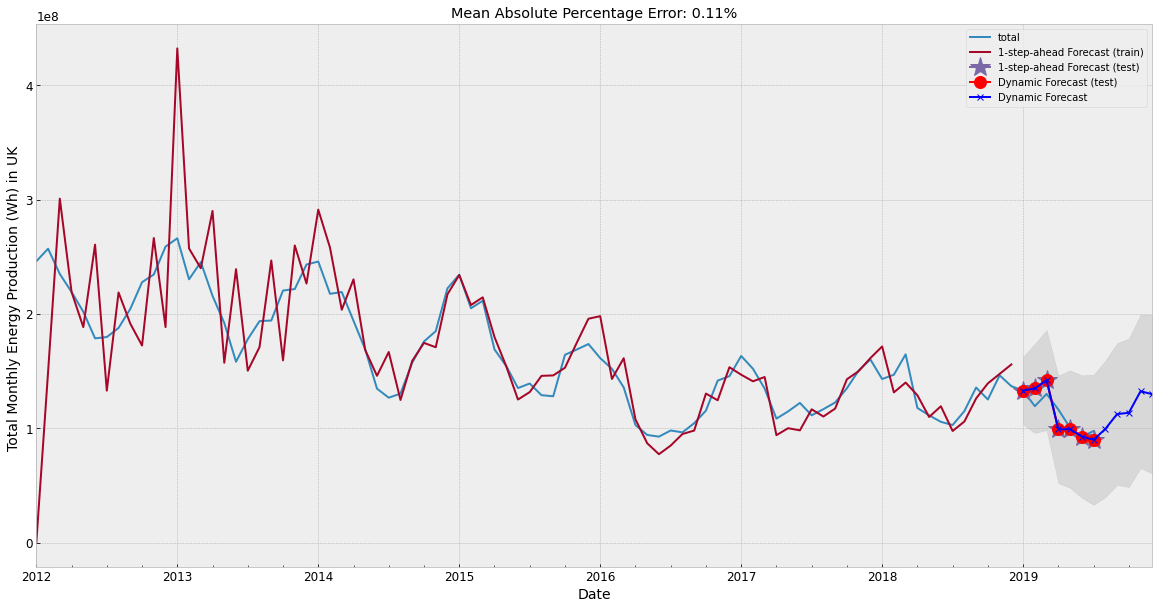

In [23]:
ax = energy_per_month['total'].plot(figsize=(20, 10))
pred0_train.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (train)')
pred0.predicted_mean.plot(ax=ax, marker='*', markersize=20, label='1-step-ahead Forecast (test)')
pred1.predicted_mean.plot(ax=ax, marker='o', color='red', markersize=12, label='Dynamic Forecast (test)')
pred2.predicted_mean.plot(ax=ax, marker='x', color= 'blue', markersize=6, label='Dynamic Forecast')
error = mape(energy_per_month['total'][12+1:], pred0_train.predicted_mean)
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='grey', alpha=.2)
plt.ylabel('Total Monthly Energy Production (Wh) in UK ')
plt.xlabel('Date')
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
plt.legend()
plt.show()

In [24]:
# for test
mape(df_test, pred1.predicted_mean)

0.06626237391150205

In [25]:
def plotSARIMA(series, model, n_steps, name, s, d):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    data = series.copy()
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error
    error = mape(data['total'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='orange', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.9, color='lightgrey')
    plt.plot(data[name], label="actual")
    plt.legend()
    plt.grid(True)


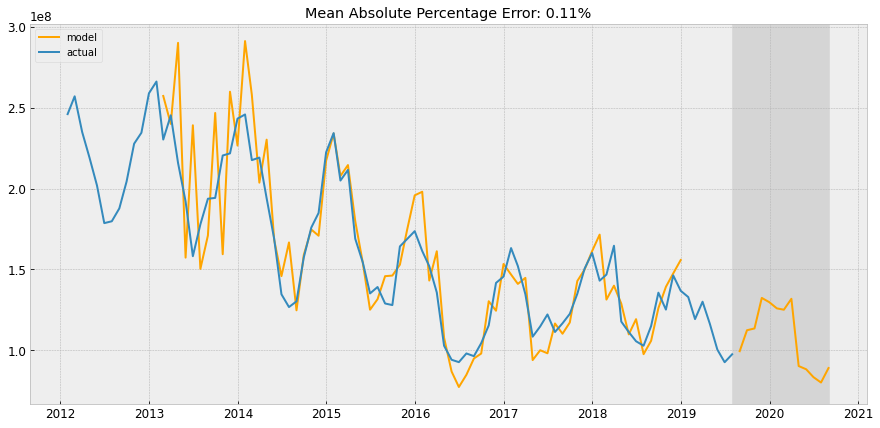

In [26]:
plotSARIMA(energy_per_month, best_model, 12, 'total', 12, 1)